The main ideal in this project is that, combining with the Carhart four-factor model, we add many other momemtum factors which take different time periods. By using PCA, we then deduce the dimensionality, and construct our positions and apply the strategy. We would gain a time series of daily returns, and finally try to establish a LSTM model on it.

I choose HS300 index as my underlying.

# The first step is to realize the Carhart four-factor model.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import akshare as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import QUANTAXIS as QA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import plotly
import os
import random
import statsmodels.tsa.seasonal as smt
from subprocess import check_output
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

# 1. Read data files

In [2]:
close_df = pd.read_csv("C:\\Users\\tianj\\Project 1\\data\\HS300_data\\close.csv", 
                       index_col = "trade_date")
return_df = pd.read_csv("C:\\Users\\tianj\\Project 1\\data\\HS300_data\\return.csv", 
                        index_col = "trade_date")
BM_df = pd.read_csv("C:\\Users\\tianj\\Project 1\\data\\HS300_data\\BM.csv", 
                    index_col = "trade_date")
MV_df = pd.read_csv("C:\\Users\\tianj\\Project 1\\data\\HS300_data\\MV.csv", 
                    index_col = "trade_date")

# Convert interest rates 
return_df = return_df / 100

In [3]:
# datetime conversion
close_df.index = pd.to_datetime(close_df.index)
return_df.index = pd.to_datetime(return_df.index)
BM_df.index = pd.to_datetime(BM_df.index)
MV_df.index = pd.to_datetime(MV_df.index)

In [4]:
deposit_interest_rate = pd.read_csv(
    "C:\\Users\\tianj\\Project 1\\data\\HS300_data\\deposit_interest_rate.csv", 
    encoding = "gbk").fillna(method = "ffill")[["pubDate", "fixedDepositRate3Month"]]

central_bank_bill = pd.read_csv(
    "C:\\Users\\tianj\\Project 1\\data\\HS300_data\\central_bank_bill.csv", 
    encoding = "gbk").fillna(method = "ffill")[["short_name", "list_date"]]

shibor = pd.read_csv(
    "C:\\Users\\tianj\\Project 1\\data\\HS300_data\\shibor.csv", 
    encoding = "gbk").fillna(method = "ffill")

# 2. Interest retes conversions.


| Time(t) | Sources |
| :--- | ----: |
| t $\leq$ 2002-08-06 | Three-month fixed deposit rates|
| 2002-08-07 $\leq$ t $\leq$ 2006-10-07 | Coupon rate of three-month central bank bills |
| 2006-10-08 $\leq$ t | Shibor |

In [5]:
deposit_interest_rate = deposit_interest_rate.rename(columns = {"fixedDepositRate3Month": "rate",
                                                                "pubDate": "date"})

deposit_interest_rate["date"] = pd.to_datetime(deposit_interest_rate["date"])

deposit_interest_rate["rate"] = (1 + deposit_interest_rate["rate"] / 100)**(1/91) - 1

In [6]:
central_bank_bill["list_date"] = pd.to_datetime(central_bank_bill["list_date"])
central_bank_bill["rate"] = None
central_bank_bill.rename(columns={"list_date": "date"}, inplace = True)
billLst = [['2003.04.30',2.1800],['2003.05.07',2.1500],['2003.05.14',2.1900],['2003.05.21',2.1500],
           ['2003.05.28',2.1900],['2003.06.04',2.1900],['2003.06.11',2.2300],['2003.06.18',2.2700],
           ['2003.06.25',2.3100],['2003.07.02',2.3100],['2003.07.09',2.3100],['2003.07.16',2.3100],
           ['2003.07.23',2.3100],['2003.07.30',2.3100],['2003.08.06',2.3100],['2003.08.13',2.2700],
           ['2003.08.20',2.3500],['2003.08.27',2.4300],['2003.09.03',2.6600],['2003.09.10',2.7100],
           ['2003.09.17',2.7100],['2003.09.24',2.6600],['2003.10.15',2.7200],['2003.10.22',2.6800],
           ['2003.10.29',2.7200],['2003.11.12',2.8000],['2003.11.19',2.7200],['2003.11.26',2.4400],
           ['2003.12.03',2.4600],['2003.12.10',2.4600],['2003.12.17',2.4600],['2003.12.24',2.4600],
           ['2003.12.31',2.4600],['2004.01.07',2.4600],['2004.01.14',2.4600],['2004.01.21',2.4600],
           ['2004.02.04',2.4600],['2004.02.11',2.3500],['2004.02.18',2.2700],['2004.02.25',2.0600],
           ['2004.03.03',1.9900],['2004.03.10',1.9100],['2004.03.17',1.8700],['2004.03.24',2.1900],
           ['2004.03.31',2.1100],['2004.04.07',2.1400],['2004.04.14',2.1400],['2004.05.19',2.8000],
           ['2004.05.26',2.7200],['2004.06.02',2.8000],['2004.06.23',2.8000],['2004.06.30',2.8800],
           ['2004.07.07',2.8400],['2004.07.14',2.8400],['2004.07.21',2.8800],['2004.08.06',2.8600],
           ['2004.08.13',2.8200],['2004.08.20',2.7400],['2004.08.27',2.6200],['2004.09.03',2.4200],
           ['2004.09.10',2.3000],['2004.09.17',2.4200],['2004.09.24',2.5000],['2004.09.29',2.4200],
           ['2004.10.15',2.4600],['2004.10.22',2.5400],['2004.10.29',2.5800],['2004.11.05',2.5800],
           ['2004.11.12',2.5300],['2004.11.19',2.5000],['2004.11.26',2.5000],['2004.12.03',2.4600],
           ['2004.12.10',2.1400],['2004.12.17',2.4600],['2004.12.24',2.6600],['2004.12.31',2.6600],
           ['2005.01.07',2.5800],['2005.01.14',2.5400],['2005.01.21',2.3800],['2005.02.18',2.3800],
           ['2005.02.25',2.2600],['2005.03.04',2.1800],['2005.03.11',2.0200],['2005.03.17',2.3800],
           ['2005.03.18',1.4500],['2005.03.25',1.2900],['2005.04.01',1.2100],['2005.04.08',1.1700],
           ['2005.04.15',1.0900],['2005.04.22',1.1700],['2005.04.29',1.0900],['2005.05.13',1.2100],
           ['2005.05.20',1.2100],['2005.05.27',1.2100],['2005.06.03',1.1700],['2005.06.10',1.0900],
           ['2005.06.17',1.0900],['2005.06.24',1.1700],['2005.07.01',1.2100],['2005.07.08',1.1500],
           ['2005.07.15',1.1300],['2005.07.22',1.1300],['2005.07.29',1.0900],['2005.08.05',1.0900],
           ['2005.08.12',1.0900],['2005.08.19',1.0500],['2005.08.26',1.0900],['2005.09.02',1.0900],
           ['2005.09.09',1.0900],['2005.09.16',1.1300],['2005.09.23',1.1700],['2005.09.30',1.1700],
           ['2005.10.14',1.1700],['2005.10.21',1.1700],['2005.10.28',1.1700],['2005.11.04',1.2200],
           ['2005.11.11',1.3700],['2005.11.18',1.4900],['2005.11.25',1.6100],['2005.12.02',1.8100],
           ['2006.02.10',1.7300],['2006.02.17',1.7300],['2006.02.24',1.7700],['2006.03.03',1.7300],
           ['2006.03.10',1.7300],['2006.03.24',1.7700],['2006.03.31',1.8100],['2006.04.07',1.8100],
           ['2006.04.14',1.8500],['2006.04.21',1.8900],['2006.04.28',1.9800],['2006.05.12',2.0200],
           ['2006.05.19',2.0200],['2006.05.26',2.0600],['2006.06.02',2.1000],['2006.06.09',2.1400],
           ['2006.06.16',2.1800],['2006.06.23',2.2600],['2006.06.30',2.3400],['2006.07.07',2.3700],
           ['2006.07.14',2.3800],['2006.07.21',2.3800],['2006.07.28',2.3800],['2006.08.04',2.4200],
           ['2006.08.11',2.4200],['2006.08.18',2.5000],['2006.08.25',2.5400],['2006.09.01',2.5400],
           ['2006.09.08',2.5000],['2006.09.15',2.4600],['2006.09.22',2.4600],['2006.09.29',2.4600],
           ['2006.10.13',2.5000]]

billLst = list(zip(*zip(list(map(lambda x: x[0],billLst)), list(map(lambda x: x[1],billLst)))))
billLst = pd.DataFrame(billLst[0], index = billLst[1]).reset_index()
billLst = billLst.rename(columns={"index": "rate", 0: "date"})
billLst["date"] = pd.to_datetime(billLst["date"])
central_bank_bill = pd.merge(central_bank_bill, billLst, how = "inner", on="date")
del central_bank_bill["rate_x"], central_bank_bill["short_name"]
central_bank_bill = central_bank_bill.rename(columns = {"rate_y": "rate"})
central_bank_bill.iloc[0, 0] = pd.to_datetime("2002-08-07")

central_bank_bill["rate"] = (1 + central_bank_bill["rate"] / 100)**(1/91) - 1


In [7]:
central_bank_bill

date      rate
0  2002-08-07  0.000310
1  2004-08-13  0.000306
2  2004-08-20  0.000297
3  2004-08-27  0.000284
4  2004-09-03  0.000263
..        ...       ...
93 2006-09-08  0.000271
94 2006-09-15  0.000267
95 2006-09-22  0.000267
96 2006-09-29  0.000267
97 2006-10-13  0.000271

[98 rows x 2 columns]

In [8]:
shibor = shibor[["date", "shibor3M"]].rename(columns = {"shibor3M": "rate"})
shibor["date"] = pd.to_datetime(shibor["date"].values)
shibor.iloc[-1, 0] = pd.to_datetime("2021-12-31")

shibor["rate"] = (1 + shibor["rate"] / 100)**(1/91) - 1

# 3. Setting parameters

In [9]:
startDate, endDate = "19950101", "20211231"

if int(startDate) > int(endDate) or int(endDate) > datetime.date.today().year * 10000 + \
        datetime.date.today().month * 100 + datetime.date.today().day:
    print("Invalid Time Interval")
    quit()

In [10]:
tradePercent = 0.1

laggedPeriod = pd.Timedelta("30 D")
windowPeriod = pd.Timedelta(str(30 * 11) + " D")
holdPeriod = pd.Timedelta("30 D")

In [11]:
def GetTradeCalender(start: str, end: str) -> pd.Series:
    cal = ak.tool_trade_date_hist_sina()
    return cal["trade_date"][
        (datetime.date(int(start[:4]),int(start[4:6]), int(start[6:])) <= cal["trade_date"]) & 
        (cal["trade_date"] <= datetime.date(int(end[:4]), int(end[4:6]), int(end[6:])))]

calender = pd.to_datetime(GetTradeCalender(startDate, endDate))

## Choose starting date

In [12]:
def CountValidData(row):
    return len(row) - sum(pd.isnull(row))

dailyValidData = pd.Series(list(map(min, close_df.apply(CountValidData, axis = 1), 
                                    return_df.apply(CountValidData, axis = 1), 
                                    BM_df.apply(CountValidData, axis = 1), 
                                    MV_df.apply(CountValidData, axis = 1))), 
                           index = calender.values, name = "trade_date")

In [13]:
print(plt.plot(dailyValidData.index, dailyValidData.values, ls="-", lw=2, label = "Valid Data Available"))

According to the plot, we may change our start date from 2012-01-01 in our final step, since when the data were becoming sufficient for conducting analysis, however, for now we just change it to 2004-01-01 to calculate the lagged factors. 

In [14]:
# Shrink the time interval to a valid length.
close_df = close_df[close_df.index >= pd.to_datetime("2004-01-01")]
return_df = return_df[return_df.index >= pd.to_datetime("2004-01-01")]
BM_df = BM_df[BM_df.index >= pd.to_datetime("2004-01-01")]
MV_df = MV_df[MV_df.index >= pd.to_datetime("2004-01-01")]
calender = calender[calender.values >= pd.to_datetime("2004-01-01")]

# 4. Calculate each factors
According to $\mathbf{\mathit{\mbox{On Persistence in Mutual Fund Performanc}}}$ by $\mathbf{\mbox{MarK M. Carhart}}$ himself, the model can be interpreted as the following formula:

$$
\mathbb{E}[r_{p,t}] - r_{f} = \alpha + \beta_{RMRF_{p,t}}RMRF_{p,t} + \beta_{SMB_{p,t}}SMB_{p,t} + \beta_{HML_{p,t}}HML_{p,t} + \beta_{UMD_{p,t}}UMD_{p,t}
$$

Where $r_{f}$ is the risk-free interest rate, RMRF is the market risk premium = $r_{M}-r_{f}$, and $\mathbb{E}[r_{p, t}]$ is the expected return of portfolio under our assumptions.

Here, we add more factors of momentums, and use the machine learning to reduce the dimensions.

In [15]:
# Daily weighted market values
def GetWeightArray(date: pd.datetime) -> np.array:
    row = MV_df[MV_df.index == date].iloc[0].values
    return row / np.nansum(row)

# Daily market return
def GetMarketReturn(date: pd.datetime) -> float:
    weight = GetWeightArray(date)
    row = return_df[return_df.index == date].iloc[0].values
    return np.nansum([weight[i]*row[i] for i in range(len(row))])


# Daily risk free interest rates 
def RF(date: pd.datetime) -> float:
    if date <= pd.to_datetime("2002-08-06"):
        df = deposit_interest_rate
        
    elif date <= pd.to_datetime("2006-10-07"):
        df = central_bank_bill
    else:
        df = shibor
    
    if shibor[date <= shibor.iloc[:, 0].values].shape[0] != 0:
        return shibor[date <= shibor.iloc[:, 0].values].iloc[0, 1]
    else:
        raise Exception("Time Interval Exceeded!")


# Daily SMB factor
def GetSMB(date: pd.datetime) -> float:
    row = list(MV_df[MV_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
        
    # filter the stocks
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    # Determine the stocks to long and short.        
    [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
    row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
    return  np.dot(weight[row <= lower_bound], returnRow[row <= lower_bound]) - np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound])
    
    
# Daily HML factor
def GetHML(date: pd.datetime) -> float:
    row = list(BM_df[BM_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    

    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
    row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
    return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[row <= lower_bound], returnRow[row <= lower_bound])


In [16]:
mom_UMD_df = return_df.copy()
for days in range(2, 13):
    mom_UMD_df = mom_UMD_df + return_df.copy().shift(days, axis = 0)
    
    
# Daily UMD factor
def GetUMD(date: pd.datetime) -> float:
    row = list(mom_UMD_df[mom_UMD_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])

In [17]:
# Define some other momentums
mom_12_2_df = return_df.copy()
for days in range(2*30+1, 12*30):
    mom_12_2_df = mom_12_2_df + return_df.copy().shift(days, axis = 0)

# Momentum for the past 12 months lagged 2 month
def mom_12_2(date: pd.datetime) -> float:
    row = list(mom_12_2_df[mom_12_2_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])


    
mom_12_7_df = return_df.copy()
for days in range(7*30+1, 12*30):
    mom_12_7_df = mom_12_7_df + return_df.copy().shift(days, axis = 0)    
    
# Momentum for the past 12 months lagged 7 month
def mom_12_7(date: pd.datetime) -> float:
    row = list(mom_12_7_df[mom_12_7_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])


    
mom_2_1_df = return_df.copy()
for days in range(30+1, 2*30):
    mom_2_1_df = mom_2_1_df + return_df.copy().shift(days, axis = 0) 

# Momentum for the past 2 months lagged 1 month
def mom_2_1(date: pd.datetime) -> float:
    row = list(mom_2_1_df[mom_2_1_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])
    
    
    
    
mom_20_10_df = return_df.copy()
for days in range(10*30+1, 20*30):
    mom_20_10_df = mom_20_10_df + return_df.copy().shift(days, axis = 0) 

# Momentum for the past 20 months lagged 10 month
def mom_20_10(date: pd.datetime) -> float:
    row = list(mom_20_10_df[mom_20_10_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound]) 
    

    
mom_20_13_df = return_df.copy()
for days in range(13*30+1, 20*30):
    mom_20_13_df = mom_20_13_df + return_df.copy().shift(days, axis = 0)    

# Momentum for the past 20 months lagged 13 month
def mom_20_13(date: pd.datetime) -> float:
    row = list(mom_20_13_df[mom_20_13_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])

In [18]:
# Daily monmemtums
# Define some other momentums
momd_10_5_df = return_df.copy()
for days in range(5, 10):
    momd_10_5_df = momd_10_5_df + return_df.copy().shift(days, axis = 0)

# Momentum for the past 10 days lagged 5 days
def momd_10_5(date: pd.datetime) -> float:
    row = list(momd_10_5_df[momd_10_5_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])
    
    

momd_25_5_df = return_df.copy()
for days in range(5, 25):
    momd_25_5_df = momd_25_5_df + return_df.copy().shift(days, axis = 0)

# Momentum for the past 25 days lagged 5 days
def momd_25_5(date: pd.datetime) -> float:
    row = list(momd_25_5_df[momd_25_5_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])
    
    
    
momd_7_2_df = return_df.copy()
for days in range(2, 7):
    momd_7_2_df = momd_7_2_df + return_df.copy().shift(days, axis = 0)

# Momentum for the past 7 days lagged 2 days
def momd_7_2(date: pd.datetime) -> float:
    row = list(momd_7_2_df[momd_7_2_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])
    

    
momd_40_10_df = return_df.copy()
for days in range(10, 40):
    momd_40_10_df = momd_40_10_df + return_df.copy().shift(days, axis = 0)

# Momentum for the past 40 days lagged 10 days
def momd_40_10(date: pd.datetime) -> float:
    row = list(momd_40_10_df[momd_40_10_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])
    
    
    
momd_30_20_df = return_df.copy()
for days in range(20, 30):
    momd_30_20_df = momd_30_20_df + return_df.copy().shift(days, axis = 0)

# Momentum for the past 30 days lagged 20 days
def momd_30_20(date: pd.datetime) -> float:
    row = list(momd_30_20_df[momd_30_20_df.index == date].iloc[0].values)
    weight = list(GetWeightArray(date))
    returnRow = list(return_df[return_df.index == date].iloc[0].values)
    
    for i in range(len(returnRow)-1, -1, -1):
        if np.isnan(returnRow[i]) or np.isnan(row[i]):
            weight.pop(i)
            returnRow.pop(i)
            row.pop(i)
            
    if row == []: 
        return np.nan
    else:
        [lower_bound, upper_bound] = np.quantile(row, [tradePercent, 1-tradePercent])
        row, weight, returnRow = np.array(row), np.array(weight), np.array(returnRow)
        return  np.dot(weight[row >= upper_bound], returnRow[row >= upper_bound]) - np.dot(weight[
            row <= lower_bound], returnRow[row <= lower_bound])

## 4.2.  Calculate the result for four-factor model

In [19]:
multiFactor = pd.DataFrame({"RF": np.nan, "MKT": np.nan, "RMRF": np.nan , "SMB": np.nan, 
                            "HML": np.nan, "UMD": np.nan, "mom_12_2":np.nan, "mom_12_7": np.nan, 
                            "mom_2_1": np.nan, "mom_20_10": np.nan, "mom_20_13": np.nan, 
                            "momd_10_5": np.nan, "momd_25_5": np.nan, "momd_7_2": np.nan, 
                            "momd_40_10": np.nan, "momd_30_20": np.nan}, 
                           index = pd.to_datetime(calender.values))

multiFactor["RF"] = np.array(map(RF, multiFactor.index))
multiFactor["MKT"] = np.array(map(GetMarketReturn, multiFactor.index))
multiFactor["RMRF"] = multiFactor["MKT"] - multiFactor["RF"]
multiFactor["SMB"] = np.array(map(GetSMB, multiFactor.index))
multiFactor["HML"] = np.array(map(GetHML, multiFactor.index))
multiFactor["UMD"] = np.array(map(GetUMD, multiFactor.index))
multiFactor["mom_12_2"] = np.array(map(mom_12_2, multiFactor.index))
del mom_12_2_df
multiFactor["mom_12_7"] = np.array(map(mom_12_7, multiFactor.index))
del mom_12_7_df
multiFactor["mom_20_10"] = np.array(map(mom_20_10, multiFactor.index))
del mom_20_10_df
multiFactor["mom_2_1"] = np.array(map(mom_2_1, multiFactor.index))
del mom_2_1_df
multiFactor["mom_20_13"] = np.array(map(mom_20_13, multiFactor.index))
del mom_20_13_df
multiFactor["momd_10_5"] = np.array(map(momd_10_5, multiFactor.index))
del momd_10_5_df
multiFactor["momd_25_5"] = np.array(map(momd_25_5, multiFactor.index))
del momd_25_5_df
multiFactor["momd_7_2"] = np.array(map(momd_7_2, multiFactor.index))
del momd_7_2_df
multiFactor["momd_40_10"] = np.array(map(momd_40_10, multiFactor.index))
del momd_40_10_df
multiFactor["momd_30_20"] = np.array(map(momd_30_20, multiFactor.index))
del momd_30_20_df

multiFactor.fillna(method="bfill", inplace=True)
return_df = return_df.loc[multiFactor.index]
return_df.drop(columns = return_df.columns[return_df.iloc[0:3, :].sum() == 0], inplace=True)
multiFactor.to_csv("C:\\Users\\tianj\\Project 1\\data\\multifactor.csv", index=True, header=True)

In [20]:
scaled_data = pd.DataFrame(StandardScaler().fit_transform(multiFactor))
scaled_data.columns = multiFactor.columns
scaled_data.index = multiFactor.index
scaled_data

RF       MKT      RMRF       SMB       HML       UMD  \
2004-01-02 -0.684437  1.452312  1.456804 -1.795572  0.058230 -0.252906   
2004-01-05 -0.684437  3.629775  3.633808 -4.147158 -0.309253 -0.252906   
2004-01-06 -0.684437  0.493796  0.498489 -0.263054 -0.228629 -0.252906   
2004-01-07 -0.684437  0.286796  0.291533 -0.143986 -0.233113 -0.252906   
2004-01-08 -0.684437  0.582649  0.587323 -0.312088 -0.086065 -0.252906   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.831960 -0.087997 -0.082148  0.180072  0.076469 -0.100582   
2021-12-28 -0.831960  0.276391  0.282163 -0.193698 -0.190914 -0.936703   
2021-12-29 -0.831960 -0.756216 -0.750226  0.596629  0.819726 -0.280441   
2021-12-30 -0.831960  0.281060  0.286831 -0.113176 -0.511690 -0.081638   
2021-12-31 -0.831960  0.128113  0.133917  0.062335  0.248269  0.164809   

            mom_12_2  mom_12_7   mom_2_1  mom_20_10  mom_20_13  momd_10_5  \
2004-01-02 -0.122065 -0.189338 -0.374783  -0.146206  -0.194479  -0.071962   
2004-01-05 -0.122065 -0.189338 -0.374783  -0.146206  -0.194479  -0.071962   
2004-01-06 -0.122065 -0.189338 -0.374783  -0.146206  -0.194479  -0.071962   
2004-01-07 -0.122065 -0.189338 -0.374783  -0.146206  -0.194479  -0.071962   
2004-01-08 -0.122065 -0.189338 -0.374783  -0.146206  -0.194479  -0.071962   
...              ...       ...       ...        ...        ...        ...   
2021-12-27  0.061886  0.186876 -0.152592   0.315907  -0.035728   0.085309   
2021-12-28  3.480145  1.814199  0.387567   1.464144   0.319147  -0.486797   
2021-12-29 -0.712702 -0.852695 -0.422609  -0.500617  -0.666683   0.953786   
2021-12-30 -0.145113 -0.933350  0.367375   1.837214   2.457048   0.108608   
2021-12-31  1.761075  0.898605  0.253776   1.071020  -0.150555  -0.049734   

            momd_25_5  momd_7_2  momd_40_10  momd_30_20  
2004-01-02   0.610238  0.594922   -3.489160    0.093311  
2004-01-05   0.610238  0.594922   -3.489160    0.093311  
2004-01-06   0.610238  0.594922   -3.489160    0.093311  
2004-01-07   0.610238  0.594922   -3.489160    0.093311  
2004-01-08   0.610238  0.594922   -3.489160    0.093311  
...               ...       ...         ...         ...  
2021-12-27   0.135782 -0.133616    0.335847   -0.424476  
2021-12-28  -0.652002 -0.830180    0.099224    0.594005  
2021-12-29  -0.260762  0.610373   -1.428903   -0.038893  
2021-12-30   0.104276  0.243128    0.405946    0.060830  
2021-12-31   0.113828  0.252672    0.125202   -0.250055  

[4375 rows x 16 columns]

<AxesSubplot:xlabel='# of components'>

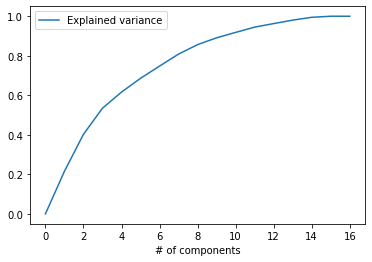

In [21]:
explained_var = []
for num in range(multiFactor.shape[1] + 1):
    pca = PCA(num)
    pca.fit(scaled_data, return_df)
    explained_var.append([num, sum(pca.explained_variance_ratio_)])
    
pd.DataFrame(explained_var, columns=["# of components", "Explained variance"]).set_index(
    "# of components").plot()

In [22]:
pca = PCA(n_components=7)
pca.fit(scaled_data, return_df)
print(f"Variance explained: {pca.explained_variance_ratio_}")
PCA_result = pd.DataFrame(pca.fit_transform(scaled_data))
PCA_result.columns = ["f1", "f2", "f3", "f4", "f5", "f6", "f7"]
PCA_result.index = multiFactor.index
PCA_result

Variance explained: [0.21573814 0.18712418 0.13201281 0.08143315 0.06973252 0.06192534
 0.06052519]


f1        f2        f3        f4        f5        f6  \
2004-01-02 -1.684379  2.597687 -0.761652 -1.325078 -0.056674  0.694733   
2004-01-05 -2.530394  6.219111 -1.223979 -0.624407 -0.197871  0.795987   
2004-01-06 -1.232375  0.723412 -0.420215 -1.676986 -0.054431  0.724496   
2004-01-07 -1.162282  0.433492 -0.381193 -1.733784 -0.044792  0.720615   
2004-01-08 -1.268939  0.851488 -0.462025 -1.653510 -0.041364  0.703699   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.054105 -0.115739  0.308105 -0.141849  0.128801  0.725702   
2021-12-28 -0.247953  0.878797  3.547994  0.831103 -1.923314  0.980499   
2021-12-29 -0.272106 -1.177744 -1.364762 -1.377535  0.498332  0.693610   
2021-12-30  0.534601  0.893904  1.765952 -0.041164  2.592242  0.359462   
2021-12-31  0.490775  0.624902  1.511794 -0.353425 -0.881954  0.711772   

                  f7  
2004-01-02 -0.088505  
2004-01-05  0.520827  
2004-01-06  0.057119  
2004-01-07  0.036928  
2004-01-08 -0.065415  
...              ...  
2021-12-27 -0.223780  
2021-12-28 -0.843057  
2021-12-29 -0.777565  
2021-12-30  0.515534  
2021-12-31 -0.717901  

[4375 rows x 7 columns]

# Construct LSTM model for stock data

In [23]:
df = pd.DataFrame(return_df.sum(axis=1))
df = pd.DataFrame(StandardScaler().fit_transform(df))
df.columns = ["return"]
df["Date"] = multiFactor.index
df = df.rename(columns={"index": "Date"})

In [24]:
# Use CPU to run the model
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [25]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

split_date: 2020-06-01
Epoch 1/5
3981/3981 - 4s - loss: 16.1409 - 4s/epoch - 1ms/step
Epoch 2/5
3981/3981 - 3s - loss: 16.1233 - 3s/epoch - 878us/step
Epoch 3/5
3981/3981 - 4s - loss: 16.1218 - 4s/epoch - 885us/step
Epoch 4/5
3981/3981 - 4s - loss: 16.1193 - 4s/epoch - 880us/step
Epoch 5/5
3981/3981 - 4s - loss: 16.1145 - 4s/epoch - 885us/step


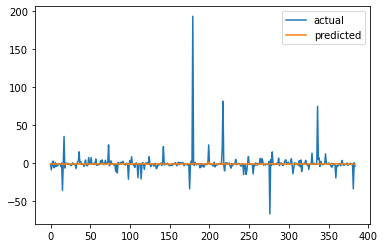

split_date: 2020-06-01
Epoch 1/5
3980/3980 - 5s - loss: 10.9338 - 5s/epoch - 1ms/step
Epoch 2/5
3980/3980 - 4s - loss: 10.9197 - 4s/epoch - 957us/step
Epoch 3/5
3980/3980 - 4s - loss: 10.9161 - 4s/epoch - 950us/step
Epoch 4/5
3980/3980 - 4s - loss: 10.9198 - 4s/epoch - 941us/step
Epoch 5/5
3980/3980 - 4s - loss: 10.9115 - 4s/epoch - 947us/step


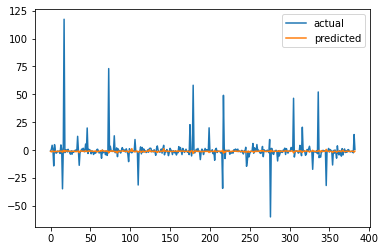

split_date: 2020-06-01
Epoch 1/5
3979/3979 - 5s - loss: 11.3503 - 5s/epoch - 1ms/step
Epoch 2/5
3979/3979 - 4s - loss: 11.3332 - 4s/epoch - 1ms/step
Epoch 3/5
3979/3979 - 4s - loss: 11.3209 - 4s/epoch - 1ms/step
Epoch 4/5
3979/3979 - 4s - loss: 11.3183 - 4s/epoch - 1ms/step
Epoch 5/5
3979/3979 - 4s - loss: 11.3090 - 4s/epoch - 1ms/step


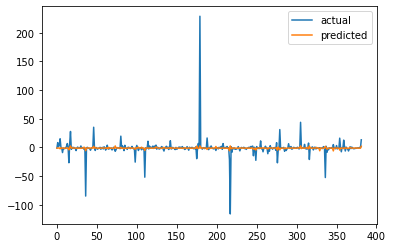

split_date: 2020-06-01
Epoch 1/5
3978/3978 - 5s - loss: 8.4297 - 5s/epoch - 1ms/step
Epoch 2/5
3978/3978 - 4s - loss: 8.4147 - 4s/epoch - 1ms/step
Epoch 3/5
3978/3978 - 4s - loss: 8.4121 - 4s/epoch - 1ms/step
Epoch 4/5
3978/3978 - 4s - loss: 8.4074 - 4s/epoch - 1ms/step
Epoch 5/5
3978/3978 - 4s - loss: 8.4053 - 4s/epoch - 1ms/step


split_date: 2020-06-01
Epoch 1/5
3977/3977 - 5s - loss: 10.3806 - 5s/epoch - 1ms/step
Epoch 2/5
3977/3977 - 5s - loss: 10.3703 - 5s/epoch - 1ms/step
Epoch 3/5
3977/3977 - 5s - loss: 10.3744 - 5s/epoch - 1ms/step
Epoch 4/5
3977/3977 - 5s - loss: 10.3700 - 5s/epoch - 1ms/step
Epoch 5/5
3977/3977 - 5s - loss: 10.3646 - 5s/epoch - 1ms/step


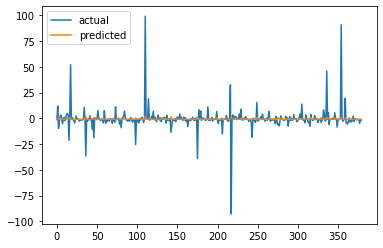

split_date: 2020-06-01
Epoch 1/5
3976/3976 - 6s - loss: 13.1201 - 6s/epoch - 1ms/step
Epoch 2/5
3976/3976 - 5s - loss: 13.1094 - 5s/epoch - 1ms/step
Epoch 3/5
3976/3976 - 5s - loss: 13.1019 - 5s/epoch - 1ms/step
Epoch 4/5
3976/3976 - 5s - loss: 13.1003 - 5s/epoch - 1ms/step
Epoch 5/5
3976/3976 - 5s - loss: 13.0956 - 5s/epoch - 1ms/step


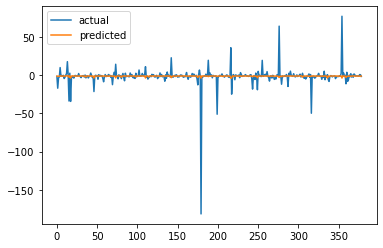

split_date: 2020-06-01
Epoch 1/5
3975/3975 - 6s - loss: 6.5981 - 6s/epoch - 2ms/step
Epoch 2/5
3975/3975 - 5s - loss: 6.5899 - 5s/epoch - 1ms/step
Epoch 3/5
3975/3975 - 5s - loss: 6.5839 - 5s/epoch - 1ms/step
Epoch 4/5
3975/3975 - 5s - loss: 6.5900 - 5s/epoch - 1ms/step
Epoch 5/5
3975/3975 - 5s - loss: 6.5827 - 5s/epoch - 1ms/step


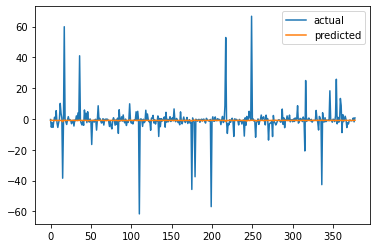

split_date: 2020-06-01
Epoch 1/5
3974/3974 - 6s - loss: 13.4643 - 6s/epoch - 2ms/step
Epoch 2/5
3974/3974 - 6s - loss: 13.4543 - 6s/epoch - 1ms/step
Epoch 3/5
3974/3974 - 6s - loss: 13.4521 - 6s/epoch - 1ms/step
Epoch 4/5
3974/3974 - 6s - loss: 13.4488 - 6s/epoch - 1ms/step
Epoch 5/5
3974/3974 - 6s - loss: 13.4387 - 6s/epoch - 1ms/step


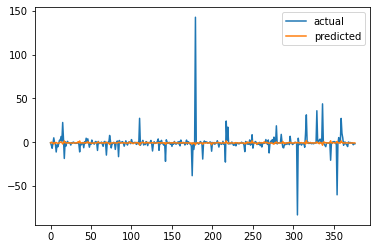

split_date: 2020-06-01
Epoch 1/5
3973/3973 - 7s - loss: 7.3606 - 7s/epoch - 2ms/step
Epoch 2/5
3973/3973 - 6s - loss: 7.3506 - 6s/epoch - 1ms/step
Epoch 3/5
3973/3973 - 6s - loss: 7.3490 - 6s/epoch - 1ms/step
Epoch 4/5
3973/3973 - 6s - loss: 7.3443 - 6s/epoch - 1ms/step
Epoch 5/5
3973/3973 - 6s - loss: 7.3404 - 6s/epoch - 1ms/step


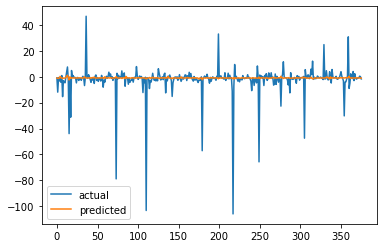

split_date: 2020-06-01
Epoch 1/5
3972/3972 - 7s - loss: 13.8478 - 7s/epoch - 2ms/step
Epoch 2/5
3972/3972 - 6s - loss: 13.8347 - 6s/epoch - 2ms/step
Epoch 3/5
3972/3972 - 6s - loss: 13.8281 - 6s/epoch - 2ms/step
Epoch 4/5
3972/3972 - 6s - loss: 13.8200 - 6s/epoch - 2ms/step
Epoch 5/5
3972/3972 - 6s - loss: 13.8070 - 6s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/5
3971/3971 - 7s - loss: 12.2154 - 7s/epoch - 2ms/step
Epoch 2/5
3971/3971 - 7s - loss: 12.2017 - 7s/epoch - 2ms/step
Epoch 3/5
3971/3971 - 8s - loss: 12.1963 - 8s/epoch - 2ms/step
Epoch 4/5
3971/3971 - 8s - loss: 12.1942 - 8s/epoch - 2ms/step
Epoch 5/5
3971/3971 - 8s - loss: 12.1954 - 8s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/5
3970/3970 - 9s - loss: 8.8355 - 9s/epoch - 2ms/step
Epoch 2/5
3970/3970 - 7s - loss: 8.8268 - 7s/epoch - 2ms/step
Epoch 3/5
3970/3970 - 7s - loss: 8.8132 - 7s/epoch - 2ms/step
Epoch 4/5
3970/3970 - 7s - loss: 8.8152 - 7s/epoch - 2ms/step
Epoch 5/5
3970/3970 - 7s - loss: 8.8095 - 7s/epoch - 2ms/step


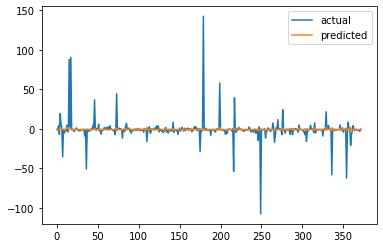

split_date: 2020-06-01
Epoch 1/5
3969/3969 - 8s - loss: 9.9439 - 8s/epoch - 2ms/step
Epoch 2/5
3969/3969 - 8s - loss: 9.9345 - 8s/epoch - 2ms/step
Epoch 3/5
3969/3969 - 8s - loss: 9.9254 - 8s/epoch - 2ms/step
Epoch 4/5
3969/3969 - 8s - loss: 9.9247 - 8s/epoch - 2ms/step
Epoch 5/5
3969/3969 - 9s - loss: 9.9165 - 9s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/5
3968/3968 - 8s - loss: 13.5348 - 8s/epoch - 2ms/step
Epoch 2/5
3968/3968 - 8s - loss: 13.5206 - 8s/epoch - 2ms/step
Epoch 3/5
3968/3968 - 9s - loss: 13.5128 - 9s/epoch - 2ms/step
Epoch 4/5
3968/3968 - 9s - loss: 13.5075 - 9s/epoch - 2ms/step
Epoch 5/5
3968/3968 - 8s - loss: 13.4979 - 8s/epoch - 2ms/step


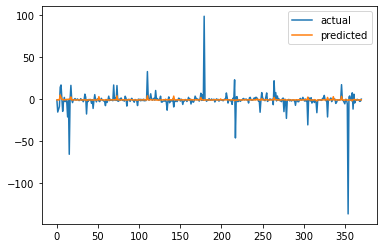

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 10s - loss: 9.4345 - 10s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4270 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4186 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4124 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4038 - 9s/epoch - 2ms/step


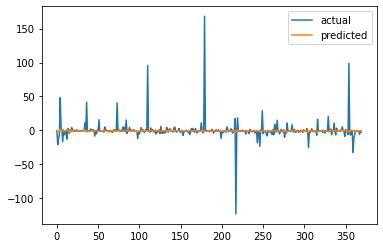

In [26]:
window_len_lst = list(range(5, 20))
window_dic = {}

for window_len in window_len_lst:
    split_date = "2020-06-01"
    print("split_date:",split_date)

    # Split the training and test set
    training_set, test_set = df[df["Date"] < split_date], df[df["Date"] >= split_date]
    training_set = training_set.drop(["Date"], 1)
    test_set = test_set.drop(["Date"], 1)

    # Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set["return"][window_len:].values/training_set[
        "return"][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set["return"][window_len:].values/test_set["return"][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    window_dic[window_len] = MAE
window_result = pd.DataFrame(window_dic.values(), window_dic.keys()).rename(columns={0: "MAE"})

In [37]:
window_result[window_result == window_result.min()].dropna()

MAE
11  3.386592

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4452 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4310 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4294 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4245 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4290 - 8s/epoch - 2ms/step


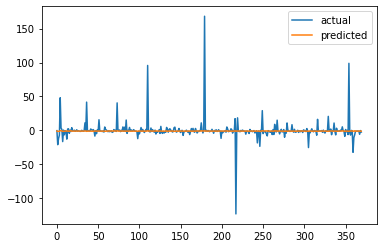

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4540 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 10s - loss: 9.4354 - 10s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 9s - loss: 9.4277 - 9s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4215 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4251 - 9s/epoch - 2ms/step


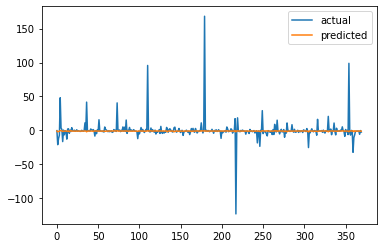

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 8s - loss: 9.4346 - 8s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 7s - loss: 9.4237 - 7s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4245 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4188 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4150 - 8s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/5
3967/3967 - 8s - loss: 9.4382 - 8s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 7s - loss: 9.4278 - 7s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4237 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4173 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4122 - 8s/epoch - 2ms/step


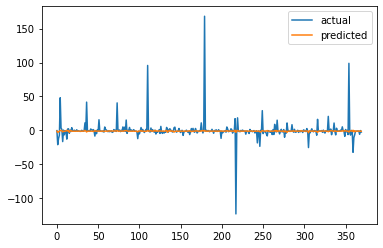

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 10s - loss: 9.4340 - 10s/epoch - 3ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4288 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4206 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4202 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4160 - 8s/epoch - 2ms/step


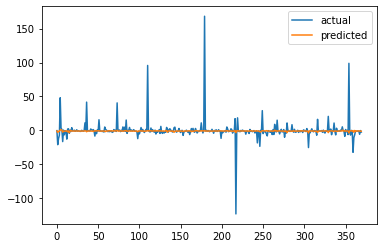

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4387 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4241 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4256 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4193 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4159 - 8s/epoch - 2ms/step


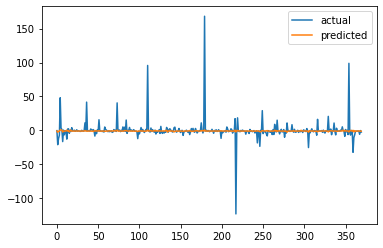

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4343 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4286 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4229 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4123 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4097 - 8s/epoch - 2ms/step


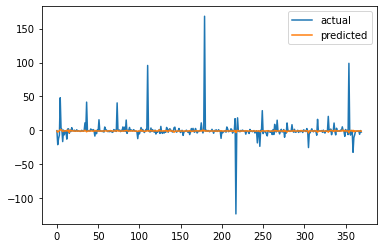

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4348 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4228 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4184 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4070 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4073 - 8s/epoch - 2ms/step


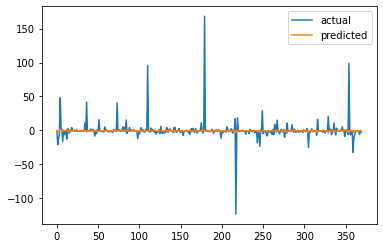

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4406 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4258 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4257 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4168 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4194 - 8s/epoch - 2ms/step


In [27]:
neurons_lst = np.arange(5, 50, 5)
neurons_dic = {}

for neurons in neurons_lst:
    split_date = "2020-06-01"
    print("split_date:",split_date)

    # Split the training and test set
    training_set, test_set = df[df["Date"] < split_date], df[df["Date"] >= split_date]
    training_set = training_set.drop(["Date"], 1)
    test_set = test_set.drop(["Date"], 1)

    # Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set["return"][window_len:].values/training_set[
        "return"][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set["return"][window_len:].values/test_set["return"][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = neurons)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    neurons_dic[neurons] = MAE
neurons_result = pd.DataFrame(neurons_dic.values(), neurons_dic.keys()).rename(columns={0: "MAE"})

In [40]:
neurons_result[neurons_result == neurons_result.min()].dropna()

MAE
35  4.18486

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 10s - loss: 9.4342 - 10s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4217 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4170 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4109 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4048 - 8s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4362 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4251 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 9s - loss: 9.4208 - 9s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4154 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4090 - 9s/epoch - 2ms/step


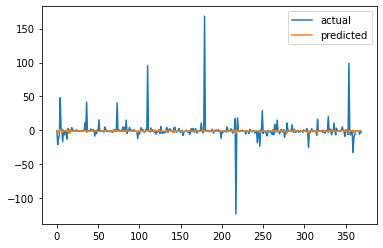

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4402 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4254 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4203 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4152 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4103 - 8s/epoch - 2ms/step


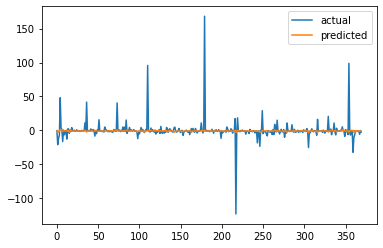

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 8s - loss: 9.4386 - 8s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4273 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4197 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4190 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4128 - 8s/epoch - 2ms/step


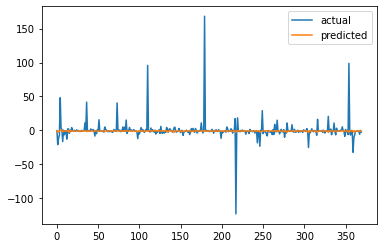

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 8s - loss: 9.4423 - 8s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4306 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4268 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4246 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4107 - 9s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/5
3967/3967 - 10s - loss: 9.4429 - 10s/epoch - 3ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4302 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 9s - loss: 9.4242 - 9s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4175 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4145 - 8s/epoch - 2ms/step


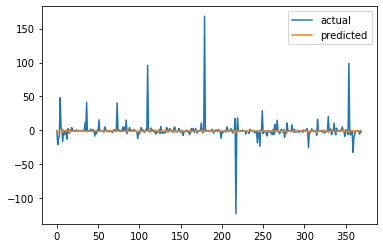

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4452 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4339 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4206 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4204 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4132 - 9s/epoch - 2ms/step


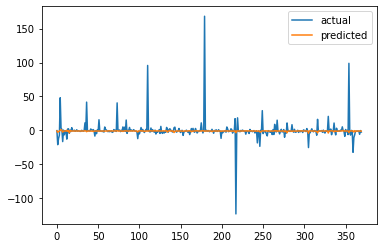

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 10s - loss: 9.4402 - 10s/epoch - 3ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4312 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 9s - loss: 9.4201 - 9s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4216 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4149 - 8s/epoch - 2ms/step


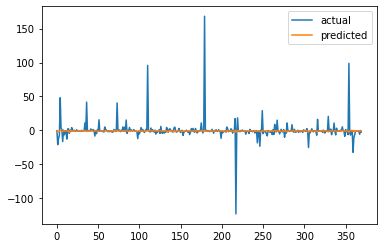

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 10s - loss: 9.4358 - 10s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4371 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4277 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4230 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4191 - 9s/epoch - 2ms/step


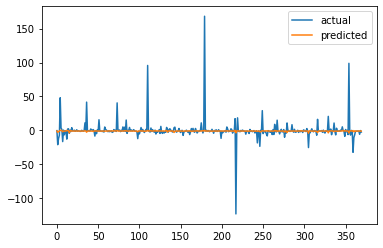

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4505 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4285 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 10s - loss: 9.4281 - 10s/epoch - 3ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4211 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4207 - 8s/epoch - 2ms/step


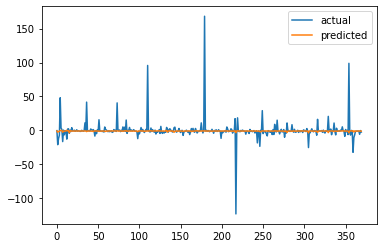

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 10s - loss: 9.4483 - 10s/epoch - 3ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4379 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 10s - loss: 9.4351 - 10s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4331 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 10s - loss: 9.4263 - 10s/epoch - 2ms/step


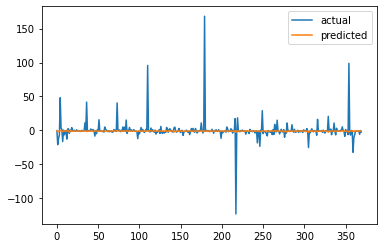

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 11s - loss: 9.4525 - 11s/epoch - 3ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4392 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4259 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4269 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4251 - 8s/epoch - 2ms/step


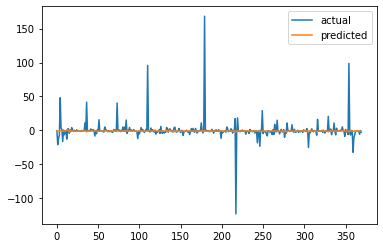

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 8s - loss: 9.4622 - 8s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4326 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4383 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4316 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 7s - loss: 9.4240 - 7s/epoch - 2ms/step


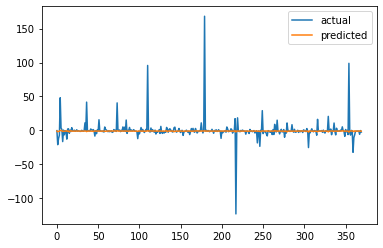

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 8s - loss: 9.4577 - 8s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4373 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4427 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4200 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4205 - 8s/epoch - 2ms/step


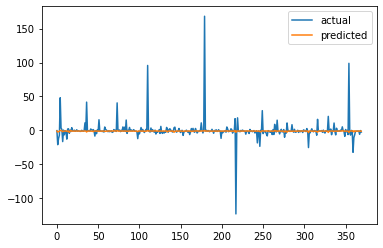

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4673 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4398 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 9s - loss: 9.4242 - 9s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 8s - loss: 9.4244 - 8s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4205 - 9s/epoch - 2ms/step


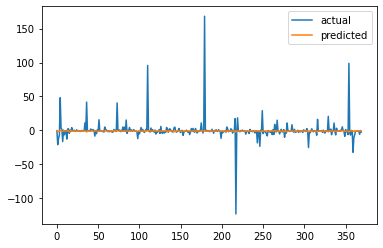

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4714 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4424 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4333 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4316 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4246 - 9s/epoch - 2ms/step


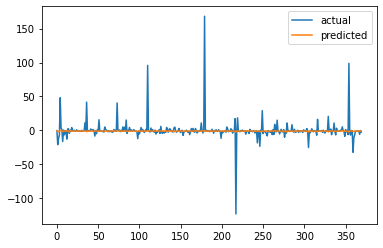

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4788 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4408 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 9s - loss: 9.4344 - 9s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 10s - loss: 9.4263 - 10s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4242 - 9s/epoch - 2ms/step


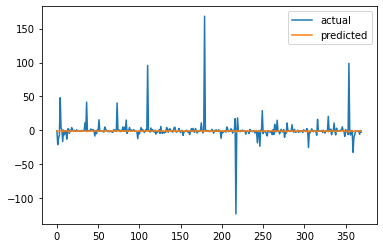

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4876 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4472 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4343 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4251 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4170 - 8s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.5018 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 9s - loss: 9.4419 - 9s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 9s - loss: 9.4367 - 9s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 10s - loss: 9.4320 - 10s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4229 - 9s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.5215 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4535 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4309 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4299 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4325 - 8s/epoch - 2ms/step


In [38]:
dropout_lst = np.arange(0, 1, 0.05)
dropout_dic = {}

for dropout in dropout_lst:
    def this_build_model(inputs, output_size, neurons, activ_func="linear", 
                         dropout=dropout, loss="mae", optimizer="adam"):
        model = Sequential()

        model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
        model.add(Dropout(dropout))
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))

        model.compile(loss="mae", optimizer=optimizer)
        return model

    split_date = "2020-06-01"
    print("split_date:", split_date)

    # Split the training and test set
    training_set, test_set = df[df["Date"] < split_date], df[df["Date"] >= split_date]
    training_set = training_set.drop(["Date"], 1)
    test_set = test_set.drop(["Date"], 1)

    # Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set["return"][window_len:].values/training_set[
        "return"][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set["return"][window_len:].values/test_set["return"][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = this_build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    dropout_dic[dropout] = MAE
dropout_result = pd.DataFrame(dropout_dic.values(), dropout_dic.keys()).rename(columns={0: "MAE"})

In [41]:
dropout_result[dropout_result==dropout_result.min()].dropna()

MAE
0.4  4.187469

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 9s - loss: 9.4361 - 9s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4241 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 9s - loss: 9.4200 - 9s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4138 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 8s - loss: 9.4076 - 8s/epoch - 2ms/step


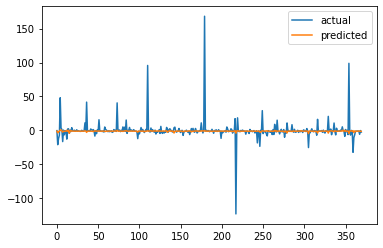

split_date: 2020-06-01
Epoch 1/10
3967/3967 - 9s - loss: 9.4331 - 9s/epoch - 2ms/step
Epoch 2/10
3967/3967 - 8s - loss: 9.4275 - 8s/epoch - 2ms/step
Epoch 3/10
3967/3967 - 9s - loss: 9.4179 - 9s/epoch - 2ms/step
Epoch 4/10
3967/3967 - 9s - loss: 9.4170 - 9s/epoch - 2ms/step
Epoch 5/10
3967/3967 - 10s - loss: 9.4077 - 10s/epoch - 2ms/step
Epoch 6/10
3967/3967 - 8s - loss: 9.4005 - 8s/epoch - 2ms/step
Epoch 7/10
3967/3967 - 8s - loss: 9.3948 - 8s/epoch - 2ms/step
Epoch 8/10
3967/3967 - 10s - loss: 9.3868 - 10s/epoch - 2ms/step
Epoch 9/10
3967/3967 - 8s - loss: 9.3789 - 8s/epoch - 2ms/step
Epoch 10/10
3967/3967 - 8s - loss: 9.3691 - 8s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/15
3967/3967 - 9s - loss: 9.4326 - 9s/epoch - 2ms/step
Epoch 2/15
3967/3967 - 9s - loss: 9.4269 - 9s/epoch - 2ms/step
Epoch 3/15
3967/3967 - 9s - loss: 9.4220 - 9s/epoch - 2ms/step
Epoch 4/15
3967/3967 - 10s - loss: 9.4221 - 10s/epoch - 2ms/step
Epoch 5/15
3967/3967 - 8s - loss: 9.4191 - 8s/epoch - 2ms/step
Epoch 6/15
3967/3967 - 9s - loss: 9.4060 - 9s/epoch - 2ms/step
Epoch 7/15
3967/3967 - 8s - loss: 9.4021 - 8s/epoch - 2ms/step
Epoch 8/15
3967/3967 - 9s - loss: 9.3902 - 9s/epoch - 2ms/step
Epoch 9/15
3967/3967 - 8s - loss: 9.3812 - 8s/epoch - 2ms/step
Epoch 10/15
3967/3967 - 8s - loss: 9.3683 - 8s/epoch - 2ms/step
Epoch 11/15
3967/3967 - 8s - loss: 9.3663 - 8s/epoch - 2ms/step
Epoch 12/15
3967/3967 - 8s - loss: 9.3466 - 8s/epoch - 2ms/step
Epoch 13/15
3967/3967 - 8s - loss: 9.3479 - 8s/epoch - 2ms/step
Epoch 14/15
3967/3967 - 8s - loss: 9.3218 - 8s/epoch - 2ms/step
Epoch 15/15
3967/3967 - 8s - loss: 9.3113 - 8s/epoch - 2ms/step


split_date: 2020-06-01
Epoch 1/20
3967/3967 - 9s - loss: 9.4432 - 9s/epoch - 2ms/step
Epoch 2/20
3967/3967 - 8s - loss: 9.4292 - 8s/epoch - 2ms/step
Epoch 3/20
3967/3967 - 9s - loss: 9.4216 - 9s/epoch - 2ms/step
Epoch 4/20
3967/3967 - 8s - loss: 9.4177 - 8s/epoch - 2ms/step
Epoch 5/20
3967/3967 - 8s - loss: 9.4116 - 8s/epoch - 2ms/step
Epoch 6/20
3967/3967 - 8s - loss: 9.4085 - 8s/epoch - 2ms/step
Epoch 7/20
3967/3967 - 8s - loss: 9.4012 - 8s/epoch - 2ms/step
Epoch 8/20
3967/3967 - 8s - loss: 9.3837 - 8s/epoch - 2ms/step
Epoch 9/20
3967/3967 - 8s - loss: 9.3852 - 8s/epoch - 2ms/step
Epoch 10/20
3967/3967 - 9s - loss: 9.3723 - 9s/epoch - 2ms/step
Epoch 11/20
3967/3967 - 10s - loss: 9.3635 - 10s/epoch - 2ms/step
Epoch 12/20
3967/3967 - 9s - loss: 9.3492 - 9s/epoch - 2ms/step
Epoch 13/20
3967/3967 - 9s - loss: 9.3352 - 9s/epoch - 2ms/step
Epoch 14/20
3967/3967 - 8s - loss: 9.3159 - 8s/epoch - 2ms/step
Epoch 15/20
3967/3967 - 8s - loss: 9.2988 - 8s/epoch - 2ms/step
Epoch 16/20
3967/3967 - 

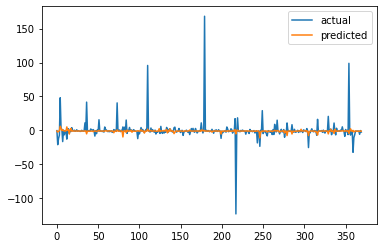

In [43]:
epochs_lst = np.arange(5, 25, 5)
epochs_dic = {}

for epochs in epochs_lst:
    def this_build_model(inputs, output_size, neurons, activ_func="linear", 
                         dropout=0.10, loss="mae", optimizer="adam"):
        model = Sequential()

        model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
        model.add(Dropout(dropout))
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))

        model.compile(loss="mae", optimizer=optimizer)
        return model

    split_date = "2020-06-01"
    print("split_date:",split_date)

    #Split the training and test set
    training_set, test_set = df[df["Date"] < split_date], df[df["Date"] >= split_date]
    training_set = training_set.drop(["Date"], 1)
    test_set = test_set.drop(["Date"], 1)

    #Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set["return"][window_len:].values/training_set[
        "return"][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set["return"][window_len:].values/test_set["return"][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = this_build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=epochs, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    epochs_dic[epochs] = MAE
epochs_result = pd.DataFrame(epochs_dic.values(), epochs_dic.keys()).rename(columns={0: "MAE"})

In [45]:
epochs_result[epochs_result == epochs_result.min()].dropna()

MAE
5  4.203348

# Conclusion

In [47]:
window = 11
neurons = 35 
dropout = 0.4
epochs = 5

In [48]:
def test_build_model(inputs, output_size, neurons, activ_func="linear", 
                     dropout=dropout, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

split_date = "2020-06-01"
print("split_date:",split_date)

# Split the training and test set
training_set, test_set = df[df["Date"] < split_date], df[df["Date"] >= split_date]
training_set = training_set.drop(["Date"], 1)
test_set = test_set.drop(["Date"], 1)

# Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()

    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

LSTM_training_inputs
LSTM_training_outputs = (training_set["return"][window_len:].values/training_set[
    "return"][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

# Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()

    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set["return"][window_len:].values/test_set["return"][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

# initialise model architecture
nn_model = test_build_model(LSTM_training_inputs, output_size=1, neurons = neurons)
# model output is next price normalised to 10th previous closing price train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=epochs, batch_size=1, verbose=2, shuffle=True)
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print("MAE: ", MAE)

split_date: 2020-06-01
Epoch 1/5
3967/3967 - 10s - loss: 9.4475 - 10s/epoch - 2ms/step
Epoch 2/5
3967/3967 - 8s - loss: 9.4348 - 8s/epoch - 2ms/step
Epoch 3/5
3967/3967 - 8s - loss: 9.4288 - 8s/epoch - 2ms/step
Epoch 4/5
3967/3967 - 9s - loss: 9.4232 - 9s/epoch - 2ms/step
Epoch 5/5
3967/3967 - 9s - loss: 9.4188 - 9s/epoch - 2ms/step


MAE:  4.20413225628425


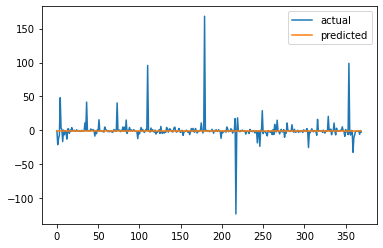

The Mean Absolute Error is: 4.202302719465017


In [49]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 10)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))